In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import yaml
from pathlib import Path
from IPython.core.display import HTML
from IPython.display import display

from oml.analysis.visualisation import RetrievalVisualizer
from oml.lightning.entrypoints.validate import pl_val
from oml.lightning.callbacks.metric import MetricValCallback
from oml.const import MOCK_DATASET_PATH
from oml.utils.download_mock_dataset import download_mock_dataset, check_mock_dataset_exists

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 330)

%matplotlib inline

In [2]:
if not check_mock_dataset_exists(MOCK_DATASET_PATH):
    download_mock_dataset(MOCK_DATASET_PATH);

In [3]:
cfg = f"""
    dataset_root: {MOCK_DATASET_PATH}
    dataframe_name: df_with_bboxes.csv
    logs_root: logs
    bs_val: 128
    num_workers: 2
    
    transforms_val:
      name: norm_resize_albu
      args:
        im_size: 224

    model:
      name: vit
      args:
        arch: vits16
        normalise_features: False
        use_multi_scale: False
        weights: vits16_dino

    metric_args:
      cmc_top_k: [1]
      map_top_k: [5]

    gpus: []
  
"""
        
trainer, ret_dict = pl_val(yaml.load(cfg, Loader=yaml.Loader));

clb_metric = [x for x in trainer.callbacks if isinstance(x, MetricValCallback)][0]
vis = RetrievalVisualizer.from_embeddings_metric(clb_metric.metric)

{'dataset_root': '/root/.cache/oml/mock_dataset', 'dataframe_name': 'df_with_bboxes.csv', 'logs_root': 'logs', 'bs_val': 128, 'num_workers': 2, 'transforms_val': {'name': 'norm_resize_albu', 'args': {'im_size': 224}}, 'model': {'name': 'vit', 'args': {'arch': 'vits16', 'normalise_features': False, 'use_multi_scale': False, 'weights': 'vits16_dino'}}, 'metric_args': {'cmc_top_k': [1], 'map_top_k': [5]}, 'gpus': []}


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Checkpoint is already here.


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'OVERALL/cmc/1': 1.0, 'OVERALL/map/5': 1.0, 'OVERALL/precision/5': 1.0}
--------------------------------------------------------------------------------


/nydl/code/open-metric-learning/oml/functional/metrics.py:68: UserWarning: Your desired k=5 more than gallery_size=4.We'll calculate metrics with k limited by the gallery size.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Q   /root/.cache/oml/mock_dataset/images/triangle_1.jpg
G 0 /root/.cache/oml/mock_dataset/images/triangle_2.jpg


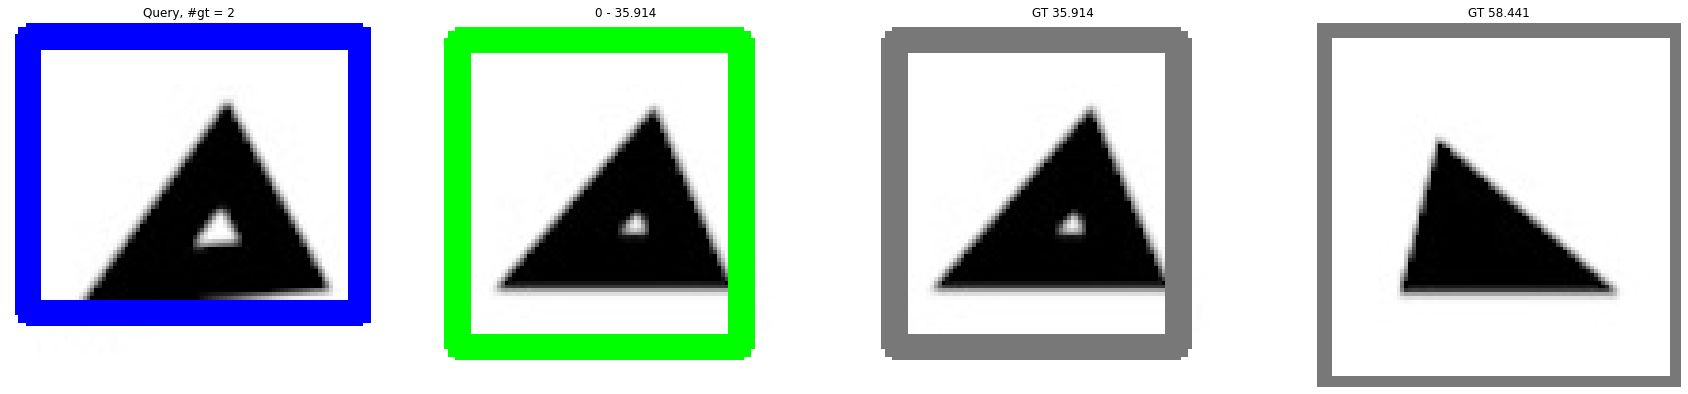

Q   /root/.cache/oml/mock_dataset/images/rectangle_1.jpg
G 0 /root/.cache/oml/mock_dataset/images/rectangle_3.jpg


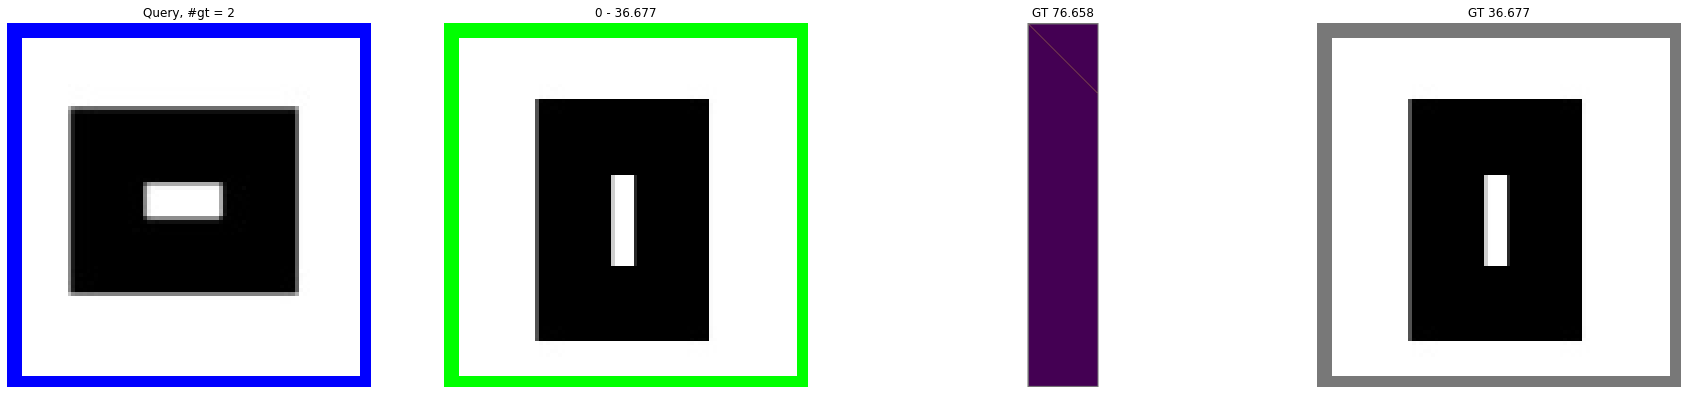

In [4]:
n_query = clb_metric.metric.distance_matrix.shape[0]

for i in range(min(10, n_query)):
    vis.visualise(query_idx=i, top_k=1, skip_no_errors=False)

In [33]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
plt.imsave('/root/.cache/oml/mock_dataset/images/rectangle_2.jpg', np.eye(1024, 200))

In [37]:
import albumentations as albu

In [42]:

albu.Compose(
    [
        albu.LongestMaxSize(max_size=100),
        albu.PadIfNeeded(min_height=100, min_width=100),
    ]
)(
    image=
)['image']

array([[0.  , 0.  , 0.5 , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.45, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

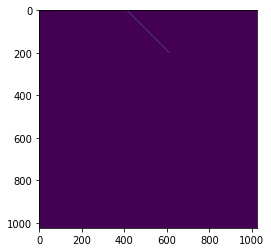

In [47]:
img = np.eye(1024, 200)


plt.imshow()

In [ ]:
import